In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import cv2
sys.path.append('../external/cocoapi/PythonAPI/')
from pycocotools.coco import COCO
sys.path.append('../external/maskrcnn-benchmark/demo')
sys.path.append('../external/maskrcnn-benchmark')
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

### Overview of this code
Goal is to evaluate the GrabCut algorithmon the dataset to see how good it is
1. Iterate through all the images
    - For each image, run the facebook net once
    - Then adjust it with user input until it is decent
    - Save data periodically

In [2]:
# Same random seed
np.random.seed(0)

In [3]:
# Image dirs
dataDir = '../../data/input/coco'
print(os.listdir(dataDir))
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
imgDir = '{}/images/{}'.format(dataDir, dataType)
print (annDir)
print (annFile)
print (annZipFile)
print (annURL)
print (imgDir)

# Mask RCNN dirs
configDir = '../external/maskrcnn-benchmark/configs/'
print (configDir)

['images', 'annotations']
../../data/input/coco/annotations
../../data/input/coco/annotations/instances_val2017.json
../../data/input/coco/annotations_trainval2017.zip
http://images.cocodataset.org/annotations/annotations_trainval2017.zip
../../data/input/coco/images/val2017
../external/maskrcnn-benchmark/configs/


In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [5]:
# get all images containing given categories, select one at random
imgIds = coco.getImgIds();
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# img = coco.loadImgs(347544)[0]
# id = 347544

In [6]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

{'license': 4, 'file_name': '000000065350.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000065350.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-20 05:15:48', 'flickr_url': 'http://farm5.staticflickr.com/4139/4869131880_ae3de10447_z.jpg', 'id': 65350}


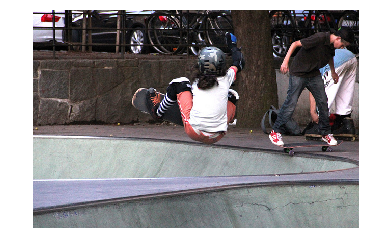

In [7]:
I = cv2.imread(os.path.join(imgDir, img['file_name']))
plt.axis('off')
imshow(I)
print(img)

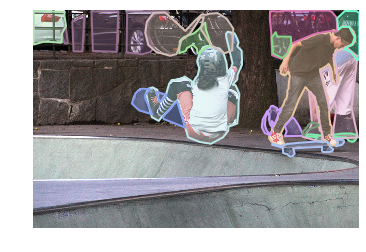

In [8]:
# load and display instance annotations
imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)


In [9]:
def iou(mask1, mask2):
    return float((mask1&mask2).sum())/((mask1|mask2).sum())

def get_largest_annotation(img_id):
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    areas = [x['area'] for x in anns]
    idx_max = np.argmax(areas)
    return anns[idx_max]

In [10]:
largest_annotation = get_largest_annotation(img['id'])
largest_mask = coco.annToMask(largest_annotation)

(221, 41, 188, 220)


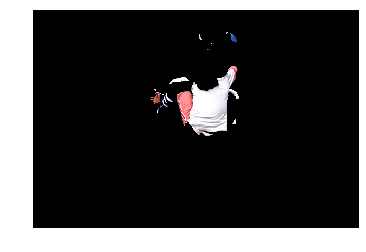

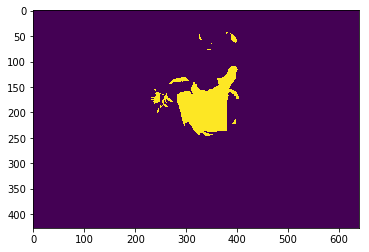

In [11]:
mask = np.zeros(I.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = tuple([int(x) for x in largest_annotation['bbox']])
print(rect)
cv2.grabCut(I,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# I = I*mask2[:,:,np.newaxis]

imshow(I*mask2[:,:,np.newaxis])
f = plt.figure()
plt.imshow(mask2)
# print(iou(mask2, largest_mask))
# f.add_subplot(1,2,1);plt.imshow(mask2)
# f.add_subplot(1,2,2);plt.imshow(largest_mask)
# plt.imshow(mask2)
# plt.imshow(largest_mask)

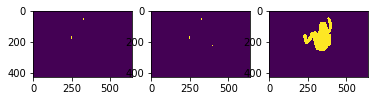

In [12]:
def get_positive_input(actual, predicted):
    region = actual&(~predicted)
    idx = np.nonzero(region)
    rand_idx = np.random.randint(len(idx[0]))
    x, y = idx[0][rand_idx], idx[1][rand_idx]
    new_mask = np.zeros(actual.shape) # new mask
    cv2.circle(new_mask, (y, x), 10, 1, -1)
    return new_mask.astype(int)&region

def get_positive_line(actual, predicted):
    region = actual&(~predicted)
    idx = np.nonzero(region)
    rand_idx_1 = np.random.randint(len(idx[0]))
    rand_idx_2 = np.random.randint(len(idx[0]))
    x1, y1 = idx[0][rand_idx_1], idx[1][rand_idx_1]
    x2, y2 = idx[0][rand_idx_2], idx[1][rand_idx_2]
    new_mask = np.zeros(actual.shape) # new mask
    cv2.line(new_mask, (y1, x1), (y2, x2), 1, 10)
    return new_mask.astype(int)&region

def get_negative_input(actual, predicted):
    region = (~actual)&predicted
    idx = np.nonzero(region)
    rand_idx = np.random.randint(len(idx[0]))
    x, y = idx[0][rand_idx], idx[1][rand_idx]
    new_mask = np.zeros(actual.shape) # new mask
    cv2.circle(new_mask, (y, x), 10, 1, -1)
    return new_mask.astype(int)&region

def get_negative_line(actual, predicted):
    region = (~actual)&predicted
    idx = np.nonzero(region)
    rand_idx_1 = np.random.randint(len(idx[0]))
    rand_idx_2 = np.random.randint(len(idx[0]))
    x1, y1 = idx[0][rand_idx_1], idx[1][rand_idx_1]
    x2, y2 = idx[0][rand_idx_2], idx[1][rand_idx_2]
    new_mask = np.zeros(actual.shape) # new mask
    cv2.line(new_mask, (y1, x1), (y2, x2), 1, 10)
    return new_mask.astype(int)&region

f = plt.figure()
f.add_subplot(1,3,1);plt.imshow(get_negative_line(largest_mask, mask2))
f.add_subplot(1,3,2);plt.imshow((~largest_mask)&mask2)
f.add_subplot(1,3,3);plt.imshow(largest_mask)

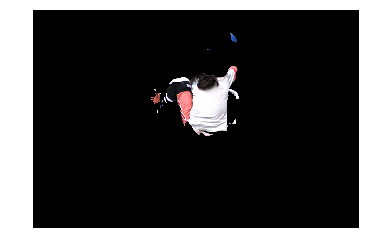

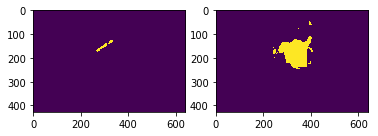

In [13]:
# newmask is the mask image I manually labelled
newmask = get_positive_line(largest_mask, mask)
# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
mask[newmask == 1] = 1
# mask[newmask == 255] = 1
mask, bgdModel, fgdModel = cv2.grabCut(I,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# I = I*mask[:,:,np.newaxis]
imshow(I*mask[:,:,np.newaxis])

f = plt.figure()
f.add_subplot(1,2,1);plt.imshow(newmask)
f.add_subplot(1,2,2);plt.imshow(mask)

# mask3 = np.copy(mask2)
# #get negative region
# negative_input = 
# f.add_subplot(1,3,1);plt.imshow(negative_input)
# mask[negative_input == 1] = 0
# cv2.grabCut(I,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
# mask3 = np.where((mask3==2)|(mask3==0),0,1).astype('uint8')
# f.add_subplot(1,3,2);plt.imshow(mask3)
# f.add_subplot(1,3,3);plt.imshow(mask3[:,:,np.newaxis]*I)

In [14]:
cv2.GC_BGD

0